# Frequent ItemSets Analysis on the [LinkedIn job skills](https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024) dataset

### Author: Adriano Meligrana

In [ ]:
# logging in into Kaggle and downloading the dataset

import os

os.environ['KAGGLE_USERNAME'] = "xxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxx"

!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024

!unzip 1-3m-linkedin-jobs-and-skills-2024.zip -d data

In [2]:
# creating the Spark session

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName('apriori') \
    .getOrCreate()

In [3]:
# importing the dataset into spark

df = spark.read.csv("./job_skills.csv", header=True, sep=",")
df = df.select(df.columns[1:])

In [4]:
# some preprocessing

from pyspark.sql import Row

def preprocessing(row):
    skills_str = row.job_skills.lower()
    skills_str = skills_str.replace(" capacities", "")    
    sskills_str = skills_str.replace(" abilities", "")
    skills_str = skills_str.replace(" skills", "")
    skills_str = skills_str.replace("decisionmaking", "decision making")
    skills_str = skills_str.replace("problemsolving", "problem solving")
    skills_str = skills_str.replace("teamwork", "team work")
    skills_str = skills_str.replace("problem-solving", "problem solving")
    skills = list(set(skills_str.split(", ")))
    return skills

def remap_rdd(row):
    row_dict = dict()
    row_dict['job_skills'] = row
    return Row(**row_dict)

df = df.na.drop()
rdd = df.rdd.map(lambda row: preprocessing(row))
rdd = rdd.map(lambda row: remap_rdd(row))
df = rdd.toDF()
df = df.repartition(6)

## Apriori algorithm implementation

In [5]:
import pyspark
import timeit
import gc
import pandas as pd
from operator import add 
from itertools import combinations

"""
apriori(df, basket_col, support_threshold = 0.01, max_frequent = 5, sample_fraction = 0.1, seed = None, cache = True, quiet = False)
  
  df                -> a PySpark DataFrame object.
  basket_col        -> the column of the dataframe containing baskets.
  support_threshold -> the percentage value of the support threshold, e.g. s = 1% -> s_threshold = 0.01.
  max_size          -> the last set size of frequent itemsets to check, e.g. if last_frequent = 2, only singletons and pairs will be checked.
  sample_fraction   -> sample fraction of baskets which will be used to find frequent itemsets.
  seed              -> seed used when sampling.
  cache             -> flag which decides if caching should be applied when running the algorithm.
  quiet             -> flag which decides if some information on the progression will be printed on screen.
"""
def apriori(df, basket_col, support_threshold = 0.01, max_size = 6, sample_fraction = 0.1, seed = None, cache = True, quiet = False):

  if sample_fraction != 1:
      df = df.sample(False, sample_fraction, seed = seed)

  rdd = df.rdd.map(lambda row: row[basket_col])
  rdd_collected = rdd.collect()
  support = int(len(rdd_collected)*support_threshold) + 1
  uniques = {e: i for i, e in enumerate(set(item for basket in rdd_collected for item in basket))}
  uniques_vec = list(uniques.keys())
  rdd = rdd.map(lambda basket: [uniques[item] for item in basket])
      
  frequent_items_dfs = []
  for i in range(max_size):
    if not quiet: print(f"Checking frequent sets of {i+1} elements")
      
    t0 = timeit.default_timer()

    frequent_items_values = None
    gc.collect()
      
    if i != 0:
        rdd = rdd.map(lambda basket: compute_frequents(basket, frequent_items, i))
        rdd = rdd.filter(lambda basket: len(basket) > i)
        if cache: rdd = rdd.persist()

    n_pass = rdd.flatMap(lambda basket: ((items, 1) for items in combinations(basket, i+1))).persist()
    n_pass = n_pass.reduceByKey(add)
    n_pass = n_pass.filter(lambda key_value: key_value[1] >= support)

    frequent_items_values = n_pass.collect()
    frequent_items = set(key_values[0] for key_values in frequent_items_values)
    frequent_items_values = sorted(frequent_items_values, key = lambda key_values: key_values[1], reverse = True)
    frequent_items_values = [(*[uniques_vec[k] for k in kv[0]], kv[1]) for kv in frequent_items_values]
    fdf = pd.DataFrame.from_records(frequent_items_values, columns=[*[f'item_{s+1}' for s in range(i+1)], "frequency"])
    frequent_items_dfs.append(fdf)

    t1 = timeit.default_timer()

    if not quiet: 
        print(f"Step number {i+1} completed in {round(t1-t0, 2)} seconds.")
        print(f"Number of frequent sets of {i+1} elements: {len(frequent_items_values)}\n")
        display(fdf)
    
  return frequent_items_dfs

def compute_frequents(basket, frequent_items, i):
    new_basket = set()
    for items in combinations(basket, i):
        if items in frequent_items:
            for item in items:
                if item not in new_basket:
                    new_basket.add(item)
    return sorted(new_basket)

In [7]:
%%time
# we managed to run the algorithm on all the data with a computer having 16gb of RAM in ~90 seconds
results = apriori(df, "job_skills", support_threshold=0.01, max_size=6, sample_fraction=1, seed=42, cache=True, quiet = False)

Checking frequent sets of 1 elements


Step number 1 completed in 19.99 seconds.
Number of frequent sets of 1 elements: 186



,item_1,frequency
0,communication,556106
1,problem solving,315495
2,customer service,289984
3,team work,251912
4,leadership,205119
...,...,...
181,english,13403
182,rn license,13361
183,ethics,13102
184,travel nursing,13004


Checking frequent sets of 2 elements


Step number 2 completed in 16.71 seconds.
Number of frequent sets of 2 elements: 298



,item_1,item_2,frequency
0,problem solving,communication,256857
1,team work,communication,200203
2,customer service,communication,195309
3,leadership,communication,150918
4,problem solving,team work,142136
...,...,...,...
293,time management,microsoft office,13029
294,budget management,communication,13001
295,decision making,attention to detail,12993
296,high school diploma,sales,12976


Checking frequent sets of 3 elements


Step number 3 completed in 15.46 seconds.
Number of frequent sets of 3 elements: 234



,item_1,item_2,item_3,frequency
0,problem solving,team work,communication,128815
1,problem solving,customer service,communication,105932
2,problem solving,leadership,communication,92867
3,customer service,team work,communication,87320
4,problem solving,time management,communication,83254
...,...,...,...,...
229,problem solving,organizational,attention to detail,13058
230,adaptability,leadership,team work,13023
231,problem solving,troubleshooting,communication,13017
232,time management,critical thinking,team work,12950


Checking frequent sets of 4 elements


Step number 4 completed in 12.89 seconds.
Number of frequent sets of 4 elements: 83



,item_1,item_2,item_3,item_4,frequency
0,problem solving,customer service,team work,communication,59312
1,problem solving,leadership,team work,communication,50462
2,problem solving,time management,team work,communication,50153
3,problem solving,attention to detail,team work,communication,46942
4,problem solving,leadership,customer service,communication,40650
...,...,...,...,...,...
78,problem solving,leadership,sales,communication,13221
79,leadership,time management,customer service,team work,13205
80,adaptability,time management,team work,communication,13195
81,problem solving,team work,analytical,communication,13079


Checking frequent sets of 5 elements


Step number 5 completed in 5.88 seconds.
Number of frequent sets of 5 elements: 12



,item_1,item_2,item_3,item_4,item_5,frequency
0,problem solving,customer service,attention to detail,team work,communication,24388
1,problem solving,time management,customer service,team work,communication,24278
2,problem solving,time management,attention to detail,team work,communication,24168
3,problem solving,leadership,customer service,team work,communication,24090
4,problem solving,leadership,time management,team work,communication,21837
5,problem solving,time management,customer service,attention to detail,communication,18249
6,problem solving,leadership,time management,customer service,communication,17651
7,problem solving,sales,customer service,team work,communication,16564
8,problem solving,leadership,attention to detail,team work,communication,15998
9,time management,customer service,attention to detail,team work,communication,14805


Checking frequent sets of 6 elements
Step number 6 completed in 1.75 seconds.
Number of frequent sets of 6 elements: 1



,item_1,item_2,item_3,item_4,item_5,item_6,frequency
0,problem solving,time management,customer service,attention to detail,team work,communication,13188


CPU times: user 17 s, sys: 1.86 s, total: 18.8 s
Wall time: 1min 34s


In [6]:
%%time
# and with only a fraction we get a better running time
apriori(df, "job_skills", support_threshold=0.01, max_size=6, sample_fraction=0.01, seed=42, cache=True, quiet = True)

CPU times: user 419 ms, sys: 54.5 ms, total: 473 ms
Wall time: 12.2 s


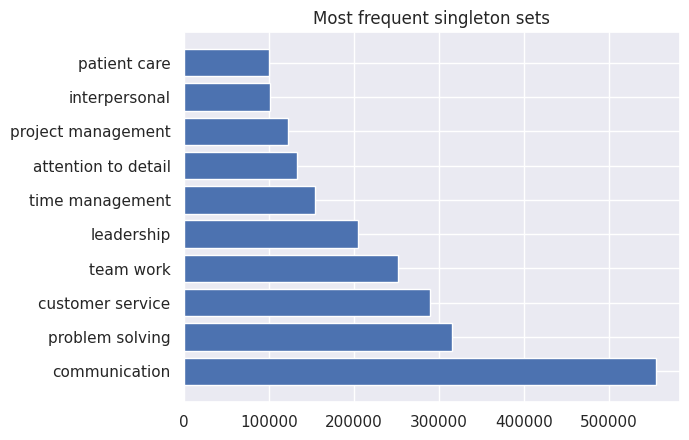

In [45]:
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set_theme()
plt.barh(results[0][:10].iloc[:,0], results[0][:10].iloc[:,1])
plt.title("Most frequent singleton sets")
plt.savefig("frequent_singetons.png", bbox_inches = "tight")